In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
import pandas as pd
from matplotlib import rc
import matplotlib as mpl
import scipy.optimize as opt
rc('text', usetex=True)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["legend.borderpad"] = 0.15
mpl.rcParams["font.size"] = 8

In [2]:
def dominant_eigval(L):
    L_sparse = L.data_as('csr_matrix')
    eval = eigs(L_sparse, k=1, which='LR', return_eigenvectors=False, ncv = 100, tol=1e-8)
    return np.real(eval[0])

In [3]:
# check the CGF for the estimation error with homodyne detection
# system parameters

N=30
phi0 = 0.1
omega_c = N/2
beta0 = 0.5
omega0 = beta0 * omega_c

# Collective spin operators 
S_x = jmat(N/2, 'x')
S_y = jmat(N/2, 'y')
S_z = jmat(N/2, 'z')
S_p = jmat(N/2, '+')
S_m = jmat(N/2, '-')
idenJ = qeye(S_z.shape[0])

def hCGF(s, omega, phi):
    return -2*s*omega*np.sin(phi)+ s**2*0.5

def deformed_L_hom(s, omega, dphi):
    H = omega*S_x
    HT = (H.dag()).conj()
    SpSmT = ((S_p*S_m).dag()).conj()
    Ls = (-1j*(tensor(idenJ, H)-tensor(HT, idenJ))+tensor(S_m.conj(), S_m) 
    -0.5*tensor(idenJ, S_p*S_m)-0.5*tensor(SpSmT, idenJ)
    -s*(np.exp(1j*dphi)*tensor(idenJ, S_m) 
    + np.exp(-1j*dphi)*tensor((S_p.dag()).conj(), idenJ))
    +s**2*0.5*tensor(idenJ,idenJ))
    return Ls

lambdas1 = np.array([[0,0,0,0,0]])
for s in np.arange(-1,1.1,0.1):
    lambda1 = dominant_eigval(deformed_L_hom(s,omega0,phi0))
    lambdas1 = np.append(lambdas1, [[N,s,beta0,phi0,lambda1]], axis=0)

In [4]:
errors1 = np.array([[0,0,0,0,0]])
for N in [30, 40, 50]:
    phi = 0.1
    s=-0.05
    omega_c = N/2
    # Collective spin operators 
    S_x = jmat(N/2, 'x')
    S_y = jmat(N/2, 'y')
    S_z = jmat(N/2, 'z')
    S_p = jmat(N/2, '+')
    S_m = jmat(N/2, '-')
    idenJ = qeye(S_z.shape[0])
    for beta in np.arange(0,1.1,0.05):
        omega = beta * omega_c
        err = abs(hCGF(s, omega, phi)-
                  dominant_eigval(deformed_L_hom(s, omega, phi)))/dominant_eigval(deformed_L_hom(s, omega, phi))
        errors1 = np.append(errors1, [[N,s,beta,phi,err]], axis=0)

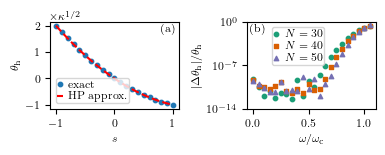

In [6]:
colors=['#1b9e77','#d95f02','#7570b3']
marker = ['o', 's', '^']

df1 = pd.DataFrame(lambdas1, columns=['N','s','beta','phi','lambda1'])
df2 = pd.DataFrame(errors1, columns=['N','s','beta','phi','err'])
fig , (ax1, ax2) = plt.subplots(1,2,figsize=(1.1*3.54331,0.45*3.54331),
                                width_ratios=[1,1], layout='tight')
ax1.scatter(df1['s'].loc[df1['N']==30], df1['lambda1'].loc[df1['N']==30], s=10, label='exact')
ax1.plot(np.linspace(-1, 1,100), hCGF(np.linspace(-1,1,100),omega0,phi0), 'r--', label='HP approx.')
ax1.legend(loc = 'lower left',labelspacing=0.2,handletextpad=0.5,handlelength=0.5)
ax1.set_ylabel(r'$\theta_\mathrm{h}$')
ax1.set_xlabel(r'$s$')
ax1.set_yticks([-1,0,1,2])
ax1.text(0.98, 0.98, '(a)', transform=ax1.transAxes, va='top', ha='right')
ax1.text(0,1.01,r'$\times\kappa^{1/2}$',transform=ax1.transAxes, ha='left', va='bottom')

ax2.scatter(df2['beta'].loc[df2['N']==30], df2['err'].loc[df2['N']==30],s=10,color=colors[0],marker=marker[0],label=r'$N=30$')
ax2.scatter(df2['beta'].loc[df2['N']==40], df2['err'].loc[df2['N']==40],s=10,color=colors[1],marker=marker[1],label=r'$N=40$')
ax2.scatter(df2['beta'].loc[df2['N']==50], df2['err'].loc[df2['N']==50],s=10,color=colors[2],marker=marker[2],label=r'$N=50$')
ax2.set_yscale('log')
ax2.set_ylim(1e-14,1e-0)
ax2.set_yticks([1e-14,1e-7,1e0])
ax2.legend(loc='best', labelspacing = 0.2, handletextpad=0.5,handlelength=0.5, bbox_to_anchor=(.15,1))
ax2.set_ylabel(r'$|\Delta \theta_\mathrm{h}|/\theta_\mathrm{h}$')
ax2.set_xlabel(r'$\omega / \omega_\mathrm{c}$')
ax2.text(0.02, 0.98, '(b)', transform=ax2.transAxes, va='top', ha='left')

fig.savefig('cgf_homodyne.pdf', dpi=1000)